## Convolutional networks for track finding on 1D detector planes

In this notebook we demonstrate the use of CNNs for hit classification of a single seeded-track, as was done in the LSTM examples.

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred, draw_train_history
from metrics import calc_hit_accuracy

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Utilities

In [2]:
def draw_2d_filters(filters, figsize=(9,3), ncols=4):
    plt.figure(figsize=figsize)
    nrows = filters.shape[0] / ncols
    for i in range(nrows):
        for j in range(ncols):
            fidx = i * ncols + j
            plt.subplot(nrows, ncols, fidx + 1)
            plt.imshow(filters[fidx].T, interpolation='none', cmap='coolwarm')
            plt.axis('off')

## Data generation

In [3]:
# Config parameters
det_width = 48
det_depth = 48
det_shape = (det_depth, det_width)
seed_size = 5

In [4]:
def batch_generator(num_events, det_shape, num_bkg_tracks, noise_prob,
                    seed_size, binary=True):
    while True:
        # Generate signal tracks in the masked region
        sig_tracks = generate_straight_tracks(num_events, det_shape)
        # Generate track background
        bkg_tracks = generate_track_bkg(num_events, det_shape,
                                        tracks_per_event=num_bkg_tracks,
                                        skip_layers=seed_size)
        # Generate noise background
        noise = generate_uniform_noise(num_events, det_shape,
                                       prob=noise_prob)
        # Combine into full events
        events = sig_tracks + bkg_tracks + noise
        if binary:
            events[events > 1] = 1

        # Mask the data
        yield events, sig_tracks

## Model definitions

In [5]:
def build_conv_model(shape, num_layers=10, num_filters=8):
    """Build the simple convolutional model"""
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 2D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutional layers
    for _ in range(num_layers):
        hidden = layers.Conv2D(num_filters, 3, 3, border_mode='same', activation='relu')(hidden)
    conv_args = dict(border_mode='same', activation='relu')
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

def build_convae_model(shape):
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutions and down-sampling
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    # Convolutions and up-sampling
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Simple CNN on multi-track events

In [6]:
# Data config
num_bkg_tracks = 5
noise_prob = 0

# Model config
num_conv_layers = 10

# Training config
batch_size = 128
num_epoch = 10
epoch_size = 102400

In [ ]:
# Prepare the batch generator
batcher1 = batch_generator(batch_size, det_shape,
                           num_bkg_tracks=num_bkg_tracks,
                           noise_prob=noise_prob, seed_size=seed_size)

# Prepare the model
model1 = build_conv_model(det_shape, num_layers=num_conv_layers)
model1.summary()

# Train the model
history1 = model1.fit_generator(batcher1, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 48, 48)     0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 48, 48)     80          reshape_1[0][0]                  
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 8, 48, 48)     584         convolution2d_1[0][0]            
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


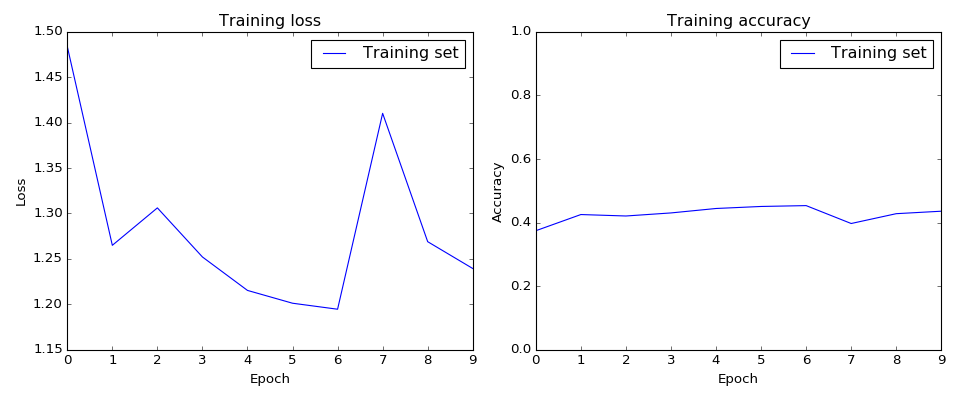

In [10]:
draw_train_history(history1, draw_val=False);

In [12]:
# Generate a test set
num_test = 10240
test1_input, test1_target = batch_generator(
    num_test, det_shape, num_bkg_tracks=num_bkg_tracks,
    noise_prob=noise_prob, seed_size=seed_size).next()

# Get test set predictions
test1_pred = model1.predict(test1_input)
test1_loss, test1_acc = model1.evaluate(test1_input, test1_target)

 9952/10240 [============================>.] - ETA: 0s

In [13]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test1_pred, test1_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test1_scores = test1_pred * test1_input
hit_accuracy = calc_hit_accuracy(test1_scores, test1_target)

# Print a test set summary
print('Test set loss', test1_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 1.23090240061
Accuracy of predicted pixel: 0.372862917878
Accuracy of classified hit:  0.43823445638


<IPython.core.display.Javascript object>


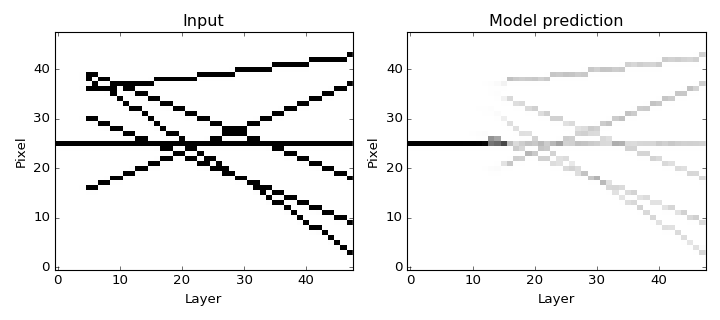

<IPython.core.display.Javascript object>


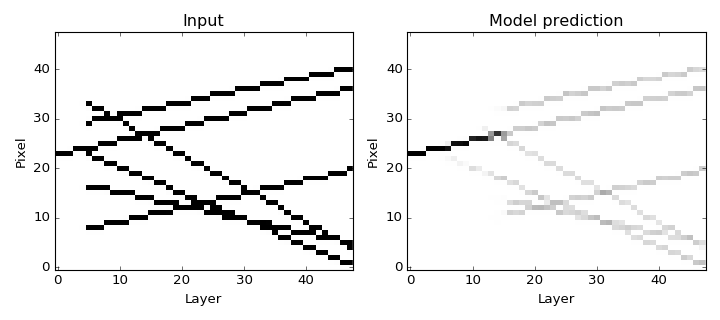

<IPython.core.display.Javascript object>


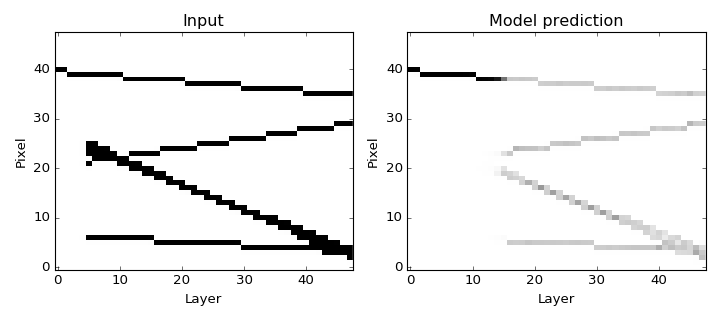

<IPython.core.display.Javascript object>


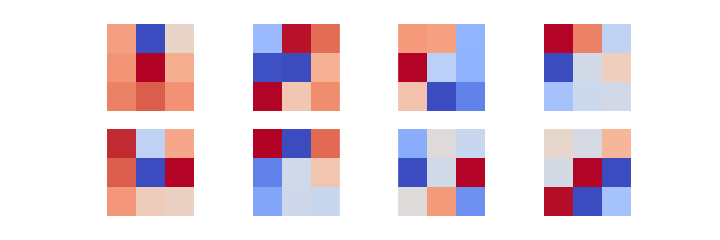

In [14]:
# Visualize some predictions
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test1_input[i], test1_pred[i], cmap='gray_r');

# Visualize cnn filters
draw_2d_filters(np.squeeze(model1.get_weights()[0]))

In [ ]:
# Prepare a deeper model
num_conv_layers = 20
model2 = build_conv_model(det_shape, num_layers=num_conv_layers)
model2.summary()

# Train the model
history2 = model2.fit_generator(batcher1, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_3 (Reshape)              (None, 1, 48, 48)     0           input_2[0][0]                    
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 8, 48, 48)     80          reshape_3[0][0]                  
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 8, 48, 48)     584         convolution2d_12[0][0]           
___________________________________________________________________________________________

In [ ]:
# Get test set predictions
test2_input, test2_target = test1_input, test1_target
test2_pred = model2.predict(test2_input)
test2_loss, test2_acc = model2.evaluate(test2_input, test2_target)

10112/10240 [============================>.] - ETA: 0s

<IPython.core.display.Javascript object>


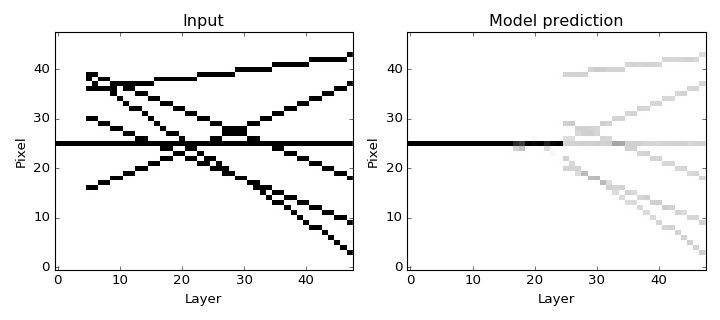

<IPython.core.display.Javascript object>


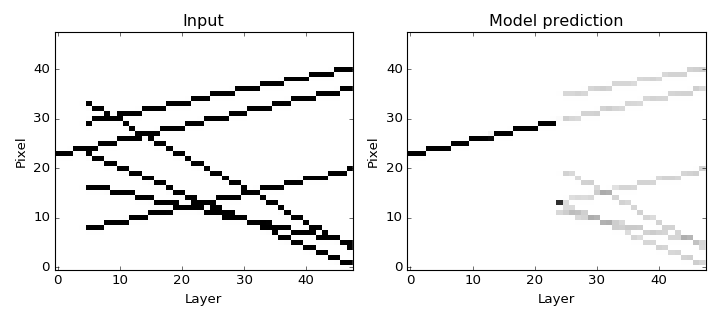

<IPython.core.display.Javascript object>


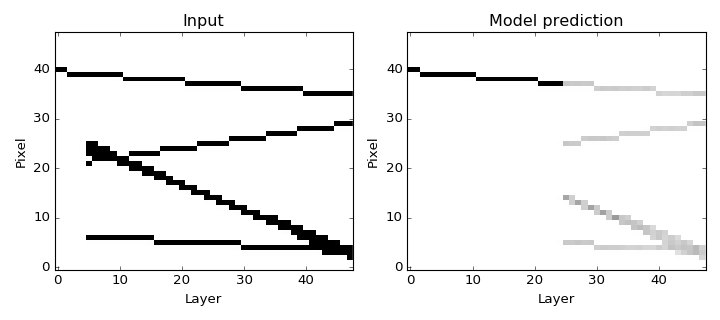

<IPython.core.display.Javascript object>


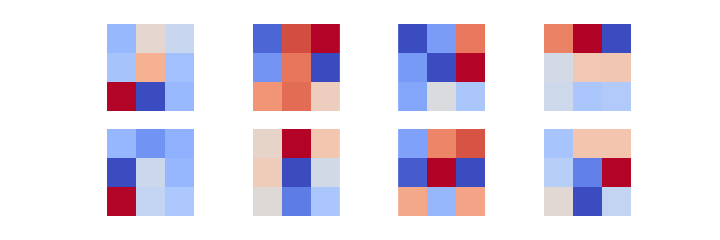

In [18]:
# Visualize some predictions
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test2_input[i], test2_pred[i], cmap='gray_r');

# Visualize cnn filters
draw_2d_filters(np.squeeze(model2.get_weights()[0]))

## Train a convolutional autoencoder

In [32]:
# Training config
num_epoch = 50

# Prepare the model
model3 = build_convae_model(det_shape)
model3.summary()

# Train the model
history3 = model3.fit_generator(batcher1, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_11 (Reshape)             (None, 1, 48, 48)     0           input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_60 (Convolution2D) (None, 8, 48, 48)     80          reshape_11[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 8, 24, 24)     0           convolution2d_60[0][0]           
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


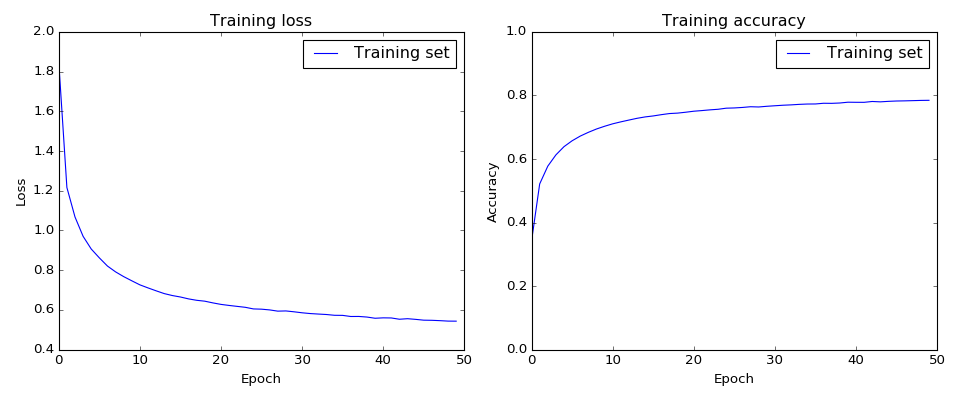

In [33]:
draw_train_history(history3, draw_val=False);

In [34]:
# Get test set predictions
test3_input, test3_target = test1_input, test1_target
test3_pred = model3.predict(test3_input)
test3_loss, test3_acc = model3.evaluate(test3_input, test3_target)

 9760/10240 [===========================>..] - ETA: 0s

In [35]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test3_pred, test3_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test3_scores = test3_pred * test3_input
hit_accuracy = calc_hit_accuracy(test3_scores, test3_target)

# Print a test set summary
print('Test set loss', test3_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 0.535555452202
Accuracy of predicted pixel: 0.766808230378
Accuracy of classified hit:  0.928070068359


<IPython.core.display.Javascript object>


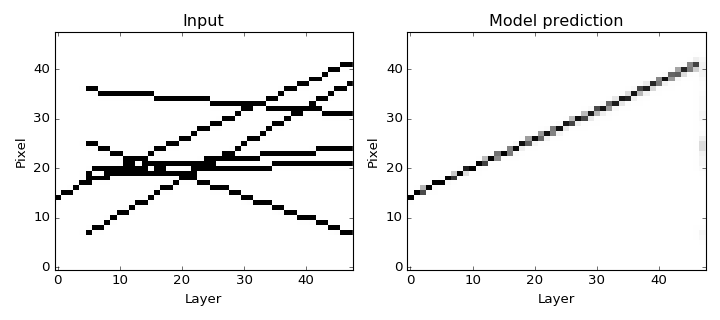

<IPython.core.display.Javascript object>


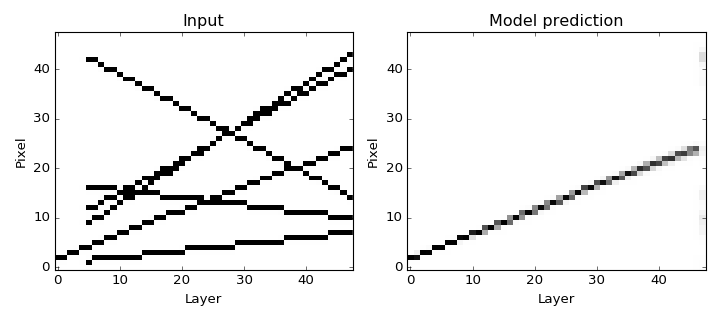

<IPython.core.display.Javascript object>


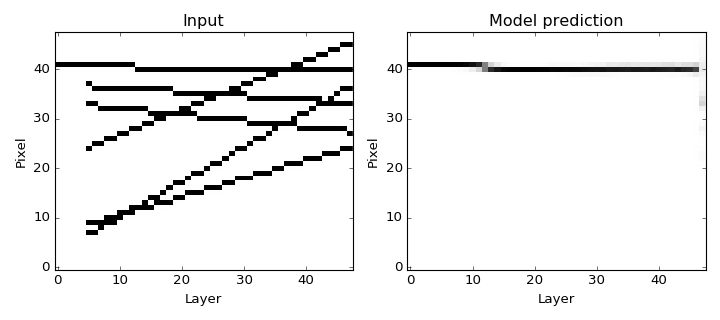

<IPython.core.display.Javascript object>


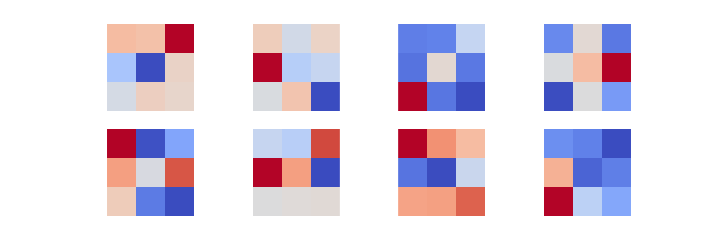

In [36]:
# Visualize some predictions
for i in [3, 4, 5]:
    draw_2d_input_and_pred(test3_input[i], test3_pred[i], cmap='gray_r');

# Visualize cnn filters
draw_2d_filters(np.squeeze(model3.get_weights()[0]))